In [14]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from process import *

# load in data
data_path='../data_extraction/data/'

cohort = pd.read_table(data_path+'cohort.tsv')

cohort.ix[cohort.age > 90, 'age']=90

urine = pd.read_csv(data_path+'urine.csv')
urine = urine.loc[urine['value'] < 5000]

maps = pd.read_csv(data_path+'map.csv')
creatinine = pd.read_csv(data_path+'creatinine.csv')
admission_creatinine = pd.read_csv(data_path+'admission_creatinine.csv')


In [15]:
# Interpolate the weights

cohort.set_index('icustay_id', inplace=True)

cohort = interpolateweights(cohort)

# Compute the urine blocks
aki_urine = calculateurineaki(urine, cohort)
cohort = pd.read_table(data_path+'cohort.tsv')

In [16]:
# Get ethnicities 
eth = geteth(cohort)

In [17]:
# clean the lactate
cohort = cohort.loc[cohort['max_lactate'] < 100]
cohort = cohort[pd.notnull(cohort['max_lactate'])]

In [18]:
# Get map features 
mean_maps, min_maps, map_fracs = getmapfeatures(maps)

Fraction of hours missing MAP values: 0.0727082162255


In [19]:
# Process creatinine values and calculate aki 
creat_summary = analyzecreatinine(creatinine, admission_creatinine)

In [20]:
# Get the logistic regression data
lr_data, aki_dataset, non_aki_dataset = getlrdata(cohort, eth, min_maps, creat_summary, aki_urine)

In [21]:
# Summarize results

#AKI
print "------------------------------- AKI Patients -------------------------------"
print "============================================================================"
get_summary(aki_dataset)

#Non-AKI
print "----------------------------- Non-AKI Patients -----------------------------"
print "============================================================================"
get_summary(non_aki_dataset)

#Overall
print "------------------------------- All Patients -------------------------------"
print "============================================================================"
get_summary(lr_data)

------------------------------- AKI Patients -------------------------------
               age          los  max_lactate    vaso_frac      min_map
count  2942.000000  2942.000000  2942.000000  2942.000000  2942.000000
mean     76.697727    12.980428     3.340445     0.159124    56.587940
std      55.131962    11.297079     2.823739     0.228874     8.733826
min      18.340391     3.001000     0.500000     0.000000    31.000000
25%      54.343115     5.344375     1.600000     0.000000    51.541663
50%      67.386841     9.314600     2.400000     0.042935    56.000000
75%      78.344660    16.317650     4.000000     0.243792    61.575000
max     309.777981   173.072500    27.700000     0.995077   102.000000

gender:
M    1502
F    1440
dtype: int64

M    0.510537
F    0.489463
dtype: float64

ethnicity:
WHITE                            2218
UNKNOWN                           340
BLACK/AFRICAN AMERICAN            194
HISPANIC/LATINO                    79
MULTI/OTHER                       

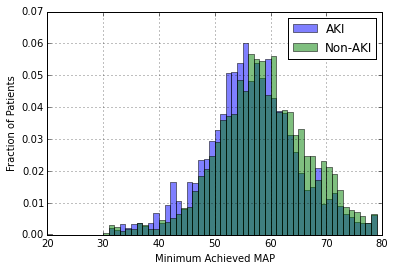

In [22]:
# Look at MAP split between AKI and Non-AKI subsets
bins = np.arange(20,80,1)

aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='AKI',normed=True)
non_aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='Non-AKI',normed=True)

plt.legend(loc='upper right')
plt.xlabel('Minimum Achieved MAP')
plt.ylabel('Fraction of Patients')
plt.show()

In [23]:
# Organize data for logistic regression

train_cols = lr_data[['age','gender','eth','los','max_lactate','vaso_frac','min_map_bin']]
train_cols['gender'] = pd.Categorical(train_cols['gender'])
train_cols['eth'] = pd.Categorical(train_cols['eth'])
train_cols['min_map_bin'] = pd.Categorical(train_cols['min_map_bin'])

train_cols['gender'] = train_cols.gender.cat.codes
train_cols['eth'] = train_cols.eth.cat.codes
train_cols['min_map_bin'] = train_cols.min_map_bin.cat.codes

# Manually add the intercept
train_cols['intercept'] = 1.0

# Do logistic regression
logit = sm.Logit(lr_data['aki'], train_cols)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.617993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    aki   No. Observations:                 4663
Model:                          Logit   Df Residuals:                     4655
Method:                           MLE   Df Model:                            7
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                 0.06146
Time:                        09:45:28   Log-Likelihood:                -2881.7
converged:                       True   LL-Null:                       -3070.4
                                        LLR p-value:                 1.657e-77
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
age             0.0036      0.001      5.092      0.000         0.002     0.005
gender         -0.0742    

In [24]:
# Get odds ratios
print np.exp(result.params)

age            1.003638
gender         0.928459
eth            1.088740
los            1.062717
max_lactate    1.051628
vaso_frac      1.722954
min_map_bin    0.824998
intercept      0.561498
dtype: float64
